# Imports

This is a notebook that you can use to generate predictions for the errors on g-g lensing. To use this notebook, you need to install colossus by Benedikt Diemer. Colossus was recently upgraded, we have not checked if this works with the latest version. You also need to specify certain parameters (e.g. bias of lens sample, properties of source sample).
The code only gives you the errors, not the amplitude of the Delta Sigma signal.

In [1]:
%matplotlib inline

#import camb
#pars = camb.CAMBparams()
from scipy.special import jn, jn_zeros
#from camb import model, initialpower
from scipy.interpolate import interp1d
from hankel_transform import *
from colossus.cosmology import cosmology
import numpy as np
from matplotlib import pylab as plt
import matplotlib.colors as colors
from astropy.cosmology import FlatLambdaCDM
from astropy import constants as const

import astropy.units as u
#rc('text', usetex=False)

In [2]:
# This is for astropy
cosmo   = FlatLambdaCDM(H0=70.0, Om0=0.3)
cosmoh1 = FlatLambdaCDM(H0=100.0,Om0=0.3)
#print(cosmo.H(0))
#print(cosmoh1.H(0))

# This is for colossus
# Check h here ...
cosmo_colossus = cosmology.setCosmology('planck15')

# Setting up the parameters for lensing and lens sample

In [3]:
zlens=0.2      # mean lens (foreground) redshift
zlens_min=0.1  # lower z cut on lens sample 
zlens_max=0.3  # upper z cut on lens sample

zsource=0.8   # source (background) redshift

# These parameters are for a HSM-REGAUSS type shape measurements method
# Shape noise
sigma_e=.36

# shape noise with responsivity factor
sigma_gamma=sigma_e/1.7

# number of background galaxies in units of N/arcmin^2
ns_angular = 18

# b of lens sample
# Bias value of the DESI BGS sample 
blens=1.33636828

# Space density of the lens sample
# Get this from simulations
n_g=0.005
g_shot_noise=1./n_g

# Overlap area between DESI and HSC area in deg^2
area=1400

In [4]:
# Convert this to a number of background galaxies in units
# of N/(Mpc/h)^2 assuming the redshift of the lens sample
# At the lens redshifts in comoving h^-1
# Ang_distance = Transverse_size/theta_rad
arcmin2rad  =  np.pi/(180.0*60)   
transverse_size = (cosmoh1.angular_diameter_distance(zlens)*arcmin2rad)  #Mpc h^-1

# comoving with h=1.
n_s=ns_angular/np.square(transverse_size)  
n_s = n_s.value
print(n_s)

# The same rmin and rmax should be used in the hankel transform.
# (or lower rmin and higher rmax)
# Otherwise, some scales will be set to 0 and covariance will be singular
#print(r_bins)
rmin=0.6
rmax=110
#rmin=0.5
#rmax=50

# Bining in h^-1 Mpc
r_bins=np.logspace(np.log10(rmin),np.log10(rmax),30) 

# Area in comoving units
area_comoving=area*(np.pi/180)**2*cosmoh1.comoving_distance(z=zlens)**2

# line of sight window lenght between Zmax and Zmin
# redshift bins lens Mpc
L_W=cosmoh1.comoving_distance(z=zlens_max)-cosmoh1.comoving_distance(z=zlens_min)
vol=area_comoving*L_W
vol=vol.value

# this is the mean density at redshift zero
# RHO_MEAN(z)  = Omega_m(z) * Rho_c(z)
rho=cosmoh1.critical_density0.to(u.Msun/(u.pc*u.pc*u.Mpc))*cosmoh1.Om0
rho=rho.value

937.2263584416348


In [5]:
def sigma_crit(cosmo, zl, zs):
    constant_term = const.c*const.c/(4*np.pi*const.G)
    dist_term = cosmo.angular_diameter_distance(zs)/(cosmo.angular_diameter_distance_z1z2(zl,zs)*\
                                                     cosmo.angular_diameter_distance(zl))
    
    return (constant_term*dist_term*(1.0/(1+zl))**2).to(u.Msun/(u.pc*u.pc))

In [6]:
# critical surface mass density
# h inverse with 1+z factors comoving
my_val = sigma_crit(cosmoh1, zlens, zsource)
 
# Shape noise
sigma_crit=my_val.value
shape_noise=sigma_crit**2*sigma_gamma**2/n_s#*cosmo.H_z(z=0.27)/cosmo.c
shape_noise 

562.0877441815603

# Get power spectrum

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


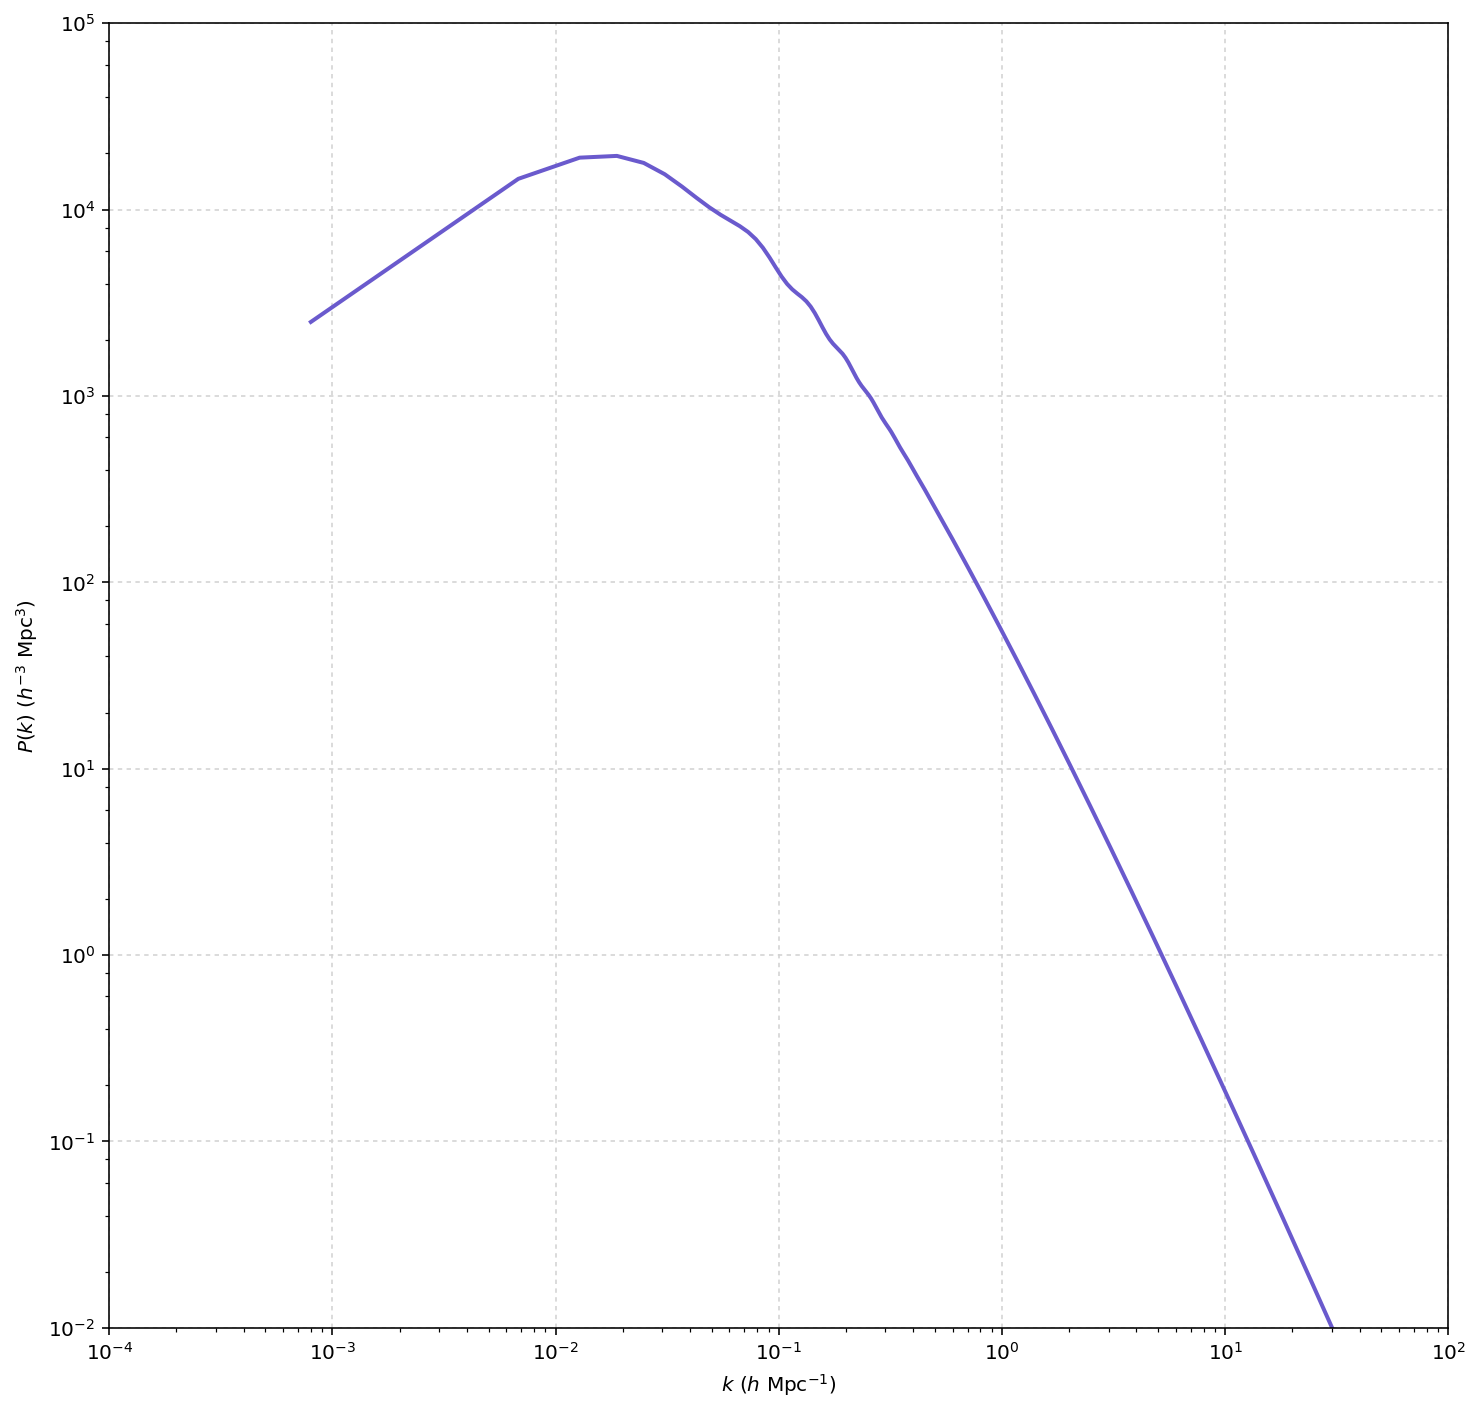

In [7]:
# NOTE: colossus only does linear MPS - in principle needs non linear MPS. 
# Differences need to be checked.
kmax=30
kmin=.8e-3
nk=5000

# Sample in log space
# In parctice, the hankel transform does its own interpolation later 
# down the line anyway and so it shouldn't matter 
step=(kmax-kmin)/nk
#print(step)

# Colosus assumes h/Mpc
kh = np.arange(kmin,kmax,step)
#print(len(kh))

# In Colossus, growth function needs to be applied here
# The wavenumber k (in comoving h/Mpc)
g2 = (cosmo_colossus.growthFactor(zlens))**2
pk = cosmo_colossus.matterPowerSpectrum(kh, 'eh98')*g2
cosmo_colossus.interpolation = True

# plot input model P(k) 
plt.figure(figsize=(12,12))
plt.xscale('log'); plt.yscale('log')
plt.ylim(1.e-2, 1.e5); plt.xlim(1.e-4, 1.e2)
plt.plot(kh , pk, c='slateblue', linewidth=2.)
plt.legend(frameon=False, loc='lower left', fontsize=7, scatterpoints=1)
plt.xlabel(r'$k\ (h\rm\ Mpc^{-1})$')
plt.ylabel(r'$P(k)\ (h^{-3}\ \rm Mpc^3)$')
plt.grid(linestyle='dotted', c='lightgray')

In [8]:
#Setting up the Hankel Transform
#This deals with the interpolation over the Bessel Functions
#This part is slower. But only needs to be run once. 
#If you only need wgg, set j_nu=[0]. For wg+ (or \Delta\Sigma) use j_nu=[2]
%time HT=hankel_transform(rmin=rmin,rmax=rmax,kmax=kmax,j_nu=[0],n_zeros=28000,kmin=kmin)

j-nu= 0  not enough zeros to cover kmin, increasing by  1000  to 29000
nr: 1047
CPU times: user 14.2 s, sys: 230 ms, total: 14.5 s
Wall time: 14.5 s


In [9]:
# Note to ourselves: double check h factors correct
# This tapers to function at the edges to make it go to zero nicely
# To avoid runing when you take the fourier transform
# Note: need atleast k=10 and k=1.e-3 to get decent wgg for 1-100 Mpc/h range.

pk_taper=HT.taper(k=kh,pk=pk,large_k_lower=5,large_k_upper=kmax,low_k_lower=kmin,
                     low_k_upper=kmin*2)

# g-g Lensing covariance

We are using the real-space DS(r_p) covariance expression from Sukhdeep Singh's paper, Eq 10.
http://adsabs.harvard.edu/abs/2016arXiv161100752S

Here we are using the part withuot the curly brackets (as explained later in the text, if you subtract DS around randoms to get the optimal estimator, you get rid of the curly brackets term)

We are ignoring the connected $T_{g \gamma g \gamma}$ term, as it’s unlikely to be very important and is so much harder to calculate, and we are just keeping the $(P_{gg} + N_g) (P_{\gamma \gamma} + N_\gamma) + P_{g \gamma}^2$ stuff, so you have lens clustering and shot noise, cosmic shear and shape noise, and cosmic variance terms.

In [10]:
%time HT=hankel_transform(rmin=rmin,rmax=rmax,kmax=kmax,j_nu=[2],n_zeros=60000,kmin=kmin)

j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 61000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 62000
nr: 1046
CPU times: user 32.6 s, sys: 707 ms, total: 33.3 s
Wall time: 33.9 s


In [11]:
# Approximation of convergence power spectrum by integration
# Dchi2 is the integral over the window function

## ******* CHECK HERE this number shouldn't be hard coded, 
Dchi2=900 #integral over product of window functions units is Mpc?
p_kappa_kappa=pk*(rho)**2*Dchi2

p_g=blens**2*pk
p_gk=blens*pk*rho

taper_kw=dict({'large_k_lower':10,'large_k_upper':kmax,'low_k_lower':kmin,'low_k_upper':kmin*1.2})

r,DS=HT.projected_correlation(k_pk=kh,pk=p_gk,j_nu=2,taper=True,**taper_kw)

# bin_mat can bin matrices of any dimension. Harder to read and can be slow in high dimensions
# Amplitude of DS computed here
r_re,DS_re=HT.bin_mat(mat=DS,r=r,r_bins=r_bins) 

# Pgg x Pgammagamma
r,cov_ggkk=HT.projected_covariance(k_pk=kh,pk1=p_g+g_shot_noise,pk2=p_kappa_kappa+shape_noise,j_nu=2,taper=True,**taper_kw)
r_re,cov_ggkk_re=HT.bin_cov(r=r,cov=cov_ggkk,r_bins=r_bins)
corr=HT.corr_matrix(cov=cov_ggkk_re)

# g gamma ^2
r,cov_gkgk=HT.projected_covariance(k_pk=kh,pk1=p_gk,pk2=p_gk,
                               kmax=100,rmin=.8,j_nu=2,rmax=110,n_zeros=3500)#return_Jrr=True,Jrr=Jrr
cov_gkgk*=Dchi2
r_re,cov_gkgk_re=HT.bin_cov(r=r,cov=cov_gkgk,r_bins=r_bins)
corr=HT.corr_matrix(cov=cov_gkgk_re)

In [12]:
# Covariance Matrix
cov_final=(cov_ggkk_re+cov_gkgk_re)/vol
corr=HT.corr_matrix(cov=cov_final)
errors=HT.diagonal_err(cov=cov_final)

#Errors
#print(r_re)
#print(errors)

[   0.65640617    0.7856253     0.94028232    1.12538489    1.34692647
    1.61208039    1.92943212    2.30925723    2.76385414    3.30794231
    3.95913887    4.73852901    5.67134871    6.78780191    8.1240384
    9.72332441   11.63744346   13.92837311   16.67029173   19.95198034
   23.87969724   28.5806186    34.20695628   40.94088634   49.00044778
   58.64660238   70.19168449   84.00951414  100.54750099]
[ 0.04636249  0.04338572  0.03349247  0.03106191  0.0284929   0.02299112
  0.02115881  0.01813573  0.0164825   0.01631513  0.01596169  0.01688083
  0.01837795  0.02055374  0.0232305   0.02625912  0.02957779  0.03314697
  0.03679279  0.0403464   0.04362857  0.046482    0.04871438  0.05013702
  0.05039177  0.04937809  0.04842379  0.0473471   0.04542731]


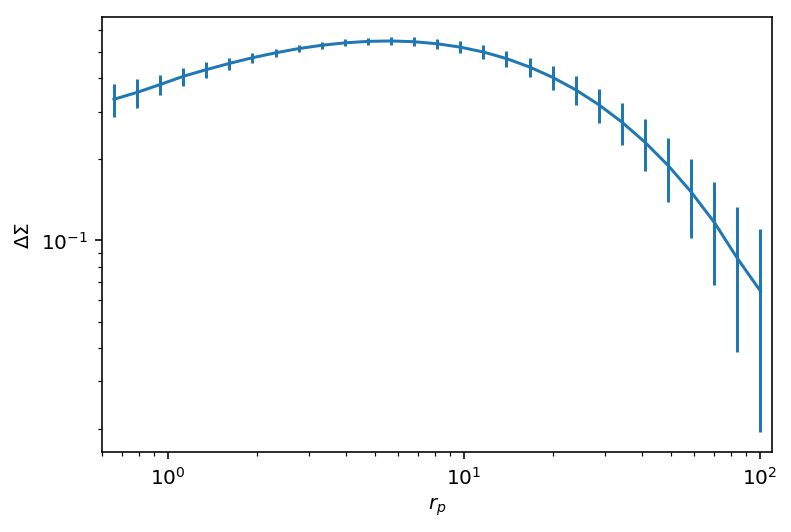

In [13]:
# DS does not have proper amplitude here because this is the non linear MPS
# r_re This are the values at the middle of the bins
plt.errorbar(r_re,DS_re,errors)
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.6,110)
plt.xlabel(r'$r_p$')
plt.ylabel(r'$\Delta\Sigma$')

(0.6, 110)

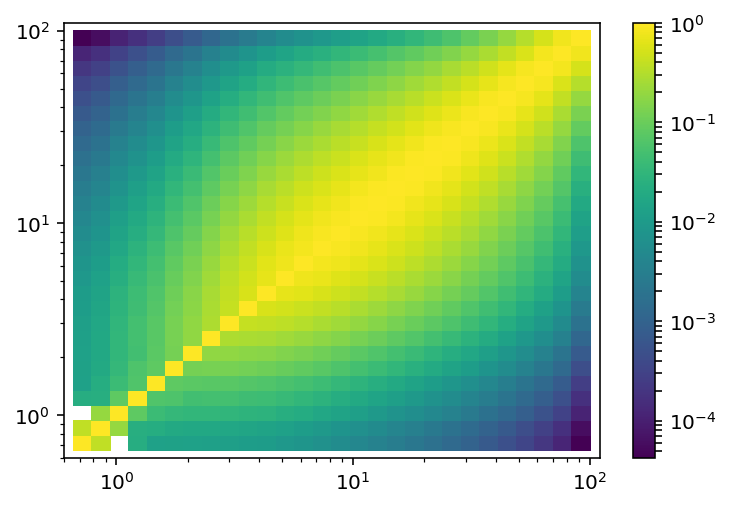

In [14]:
plt.pcolor(r_re,r_re,corr,norm=colors.LogNorm())
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlim(HT.rmin,HT.rmax)
plt.ylim(HT.rmin,HT.rmax)

In [15]:
#compute signal to noise
cov_inv=np.linalg.inv(cov_final)
SN=np.sqrt(np.dot(DS_re,np.dot(cov_inv,DS_re)))
print(SN)

49.9781440651


In [16]:
# Make a figure with the proper amplitude for DS
from colossus.halo import profile_nfw
from colossus.halo import profile_outer
from colossus.halo import bias

In [17]:
# Define an NFW object
# Add the two halo term here as well
#be = 3 # Figure 18 Benedikt paper
be=4
z=0.3
twohalo = profile_outer.OuterTermPowerLaw(norm=be,slope=1.5, z=z,pivot='rs',pivot_factor=10)
p = profile_nfw.NFWProfile(M = 1E14, c = 5.0, mdef = '200m', z = 0.3,outer_terms = [twohalo])

# r should be in kpc
r=np.logspace(1.5, 4.7, num=40, endpoint=True, base=10.0, dtype=None)
r_mpc = r/1E3

In [28]:
# DS term
#ds = p.deltaSigma(r)
#ds = ds/1E6

# At the points where errors are calcualted
r_re_kpc = r_re*1e3
ds = p.deltaSigma(r_re_kpc)/1E6

print(len(r_re))
print(len(ds))
print(len(errors))

29
29
29


/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


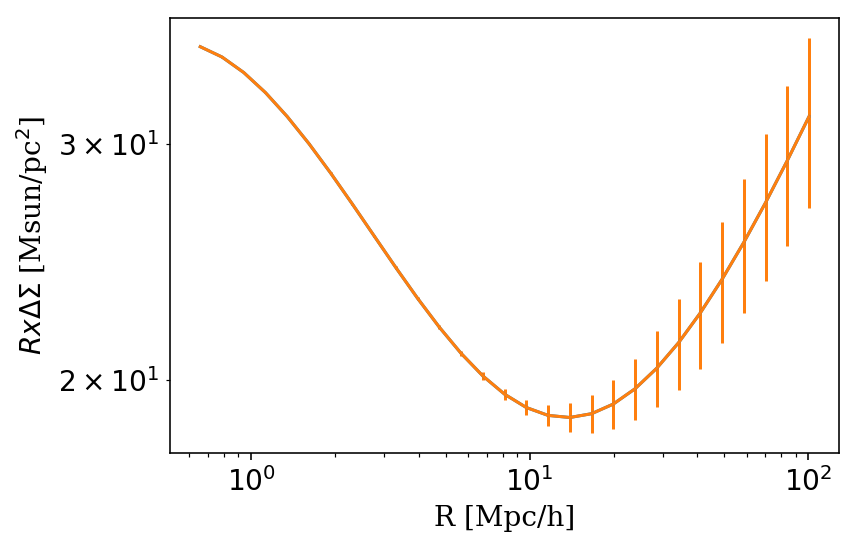

In [31]:
plt.figure()
plt.xscale('log')
plt.xlabel('R [Mpc/h]')
plt.yscale('log')
plt.ylabel('$Rx\Delta\Sigma$ [Msun/pc$^2$]')   # units are different by 1E6
#plt.plot(r_re, ds*r_re, '-',label = 'BGS Lensing Signal')
plt.plot(r_re, ds*r_re, '-')
plt.errorbar(r_re, ds*r_re,errors*r_re)
plt.rc('font', size=14)
#plt.plot(r, sigma_fit, '-', label = 'fit');
#plt.plot(r, ds_2h, '-', label = 'Best fit plus two halo')
plt.legend()

In [32]:
# Compute SN with proper amplitude
cov_inv=np.linalg.inv(cov_final)
SN=np.sqrt(np.dot(ds,np.dot(cov_inv,ds)))
print(SN)

2199.19767456
